In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [ ]:
!pip install pyyaml==5.4.1

     |████████████████████████████████| 636 kB 4.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## yolov5 clone

In [ ]:
%cd /content
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
from IPython.display import Image, clear_output

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 13661, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 13661 (delta 63), reused 67 (delta 47), pack-reused 13569
Receiving objects: 100% (13661/13661), 12.20 MiB | 26.20 MiB/s, done.
Resolving deltas: 100% (9531/9531), done.
/content/yolov5


## train, validation image파일 불러오기

In [ ]:
from glob import glob

train_img_list = glob('/content/drive/MyDrive/Colab Notebooks/guide_Emergency_exit/train/images/*.jpg')
valid_img_list = glob('/content/drive/MyDrive/Colab Notebooks/guide_Emergency_exit/valid/images/*.jpg')
print(len(train_img_list), len(valid_img_list))

133 29


In [ ]:
%mkdir /content/yolov5/Emergency_exit

In [ ]:
import yaml

with open('/content/yolov5/Emergency_exit/train.txt', 'w') as f:
  f.write('\n'.join(train_img_list) + '\n')
  
with open('/content/yolov5/Emergency_exit/valid.txt', 'w') as f:
  f.write('\n'.join(valid_img_list) + '\n')

## 파일 쓰는 함수

In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writefile(line, cell):
  with open(line, 'w') as f:
    f.write(cell.format(**globals()))

## 경로 지정

In [ ]:
%%writefile /content/yolov5/Emergency_exit/data.yaml

train: /content/drive/MyDrive/Colab Notebooks/guide_Emergency_exit/train/images
val: /content/drive/MyDrive/Colab Notebooks/guide_Emergency_exit/valid/images

nc: 1
names: ['Emergency_exit']

In [ ]:
%cat /content/yolov5/Emergency_exit/data.yaml


train: /content/drive/MyDrive/Colab Notebooks/guide_Emergency_exit/train/images
val: /content/drive/MyDrive/Colab Notebooks/guide_Emergency_exit/valid/images

nc: 1
names: ['Emergency_exit']

In [ ]:
import yaml

with open('/content/yolov5/Emergency_exit/data.yaml', 'r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])

%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

## 커스텀 yaml파일 만들기

In [ ]:
%%writefile /content/yolov5/models/cumstom_yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%cat /content/yolov5/models/cumstom_yolov5s.yaml


# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

## 학습

In [ ]:
# %%time

# %cd /content/yolov5/

# !python train.py --img 416 --batch 16 --epochs 70 --data ./Emergency_exit/data.yaml --cfg ./models/cumstom_yolov5s.yaml --weights yolov5s.pt --name Emergency_exit_guide_yolov5s_results

/content/yolov5
train: weights=yolov5s.pt, cfg=./models/cumstom_yolov5s.yaml, data=./Emergency_exit/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=70, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=Emergency_exit_guide_yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-211-gcee5959 Python-3.7.13 torch-1.11.0+cu113 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, an

## 학습 완료된 best.pt 드라이브에 저장

In [ ]:
%mkdir /content/drive/MyDrive/'Colab Notebooks'/Emergency_exit_model_70
%cp /content/yolov5/runs/train/Emergency_exit_guide_yolov5s_results/weights/best.pt /content/drive/MyDrive/'Colab Notebooks'/Emergency_exit_model_70

mkdir: cannot create directory ‘/content/drive/MyDrive/Colab Notebooks/Emergency_exit_model_70’: File exists


파일 불러오기

In [ ]:
%cd /content/yolov5/test_images
# 파일 올리기
from google.colab import files 
uploaded = files.upload()

저장된 best.pt 가져와서 예측하기

In [ ]:
%cd /content/yolov5
!python detect.py --weights /content/yolov5/runs/train/Emergency_exit_guide_yolov5s_results/weights/best.pt --source /content/drive/MyDrive/'Colab Notebooks'/exit_video.mp4

/content/yolov5
detect: weights=['/content/yolov5/runs/train/Emergency_exit_guide_yolov5s_results/weights/best.pt'], source=/content/drive/MyDrive/Colab Notebooks/exit_video.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-211-gcee5959 Python-3.7.13 torch-1.11.0+cu113 CPU

Fusing layers... 
cumstom_YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/1380) /content/drive/MyDrive/Colab Notebooks/exit_video.mp4: 384x640 2 Emergency_exits, Done. (0.253s)
video 1/1 (2/1380) /content/drive/MyDrive/Colab Notebooks/exit_video.mp4: 384x640 2 Emergency_exits, Done. (0.252s)
video 1/1 (3/1380) /content/drive/MyDrive/C

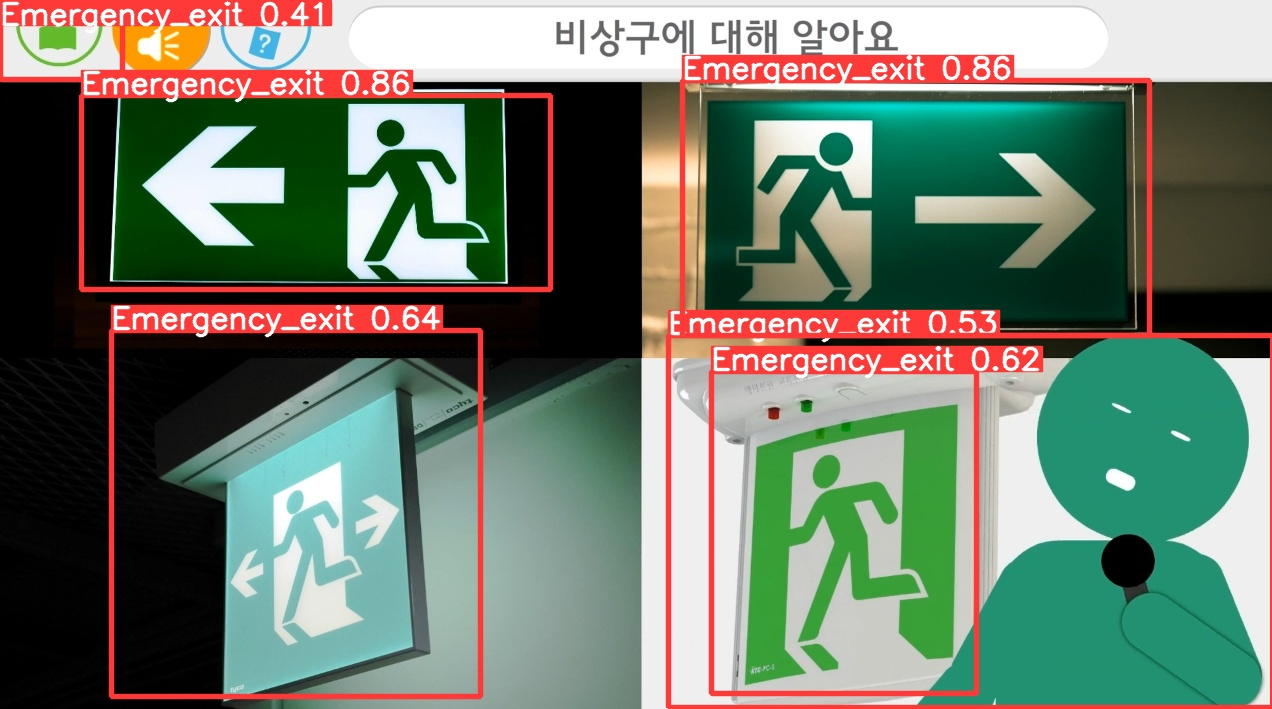

In [ ]:
import glob
import random
from IPython.display import Image, display

image_name = random.choice(glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'))
display(Image(filename=image_name))

In [ ]:
import shutil
shutil.rmtree('/content/yolov5/runs/detect/exp')